# House Prediction - Regression 

In [1]:
# let's do all the necessary importation
# Don't worry, there will be no taxation
#Just relax and let's roll

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,FunctionTransformer,OneHotEncoder
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import ColumnTransformer,make_column_selector

from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

### Now, let's load and explore our data

In [2]:
train_data_original = pd.read_csv('Housing_dataset_train.csv',index_col="ID")
test_data = pd.read_csv('Housing_dataset_test.csv',index_col="ID")

# let's make a copy
train_data = train_data_original.copy()

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 3583 to 8787
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            12187 non-null  object 
 1   title          12278 non-null  object 
 2   bedroom        12201 non-null  float64
 3   bathroom       12195 non-null  float64
 4   parking_space  12189 non-null  float64
 5   price          14000 non-null  float64
dtypes: float64(4), object(2)
memory usage: 765.6+ KB


#### We have some missing data

In [4]:
train_data.describe()

,bedroom,bathroom,parking_space,price
count,12201.000000,12195.000000,12189.000000,1.400000e+04
mean,4.308171,3.134235,3.169825,2.138082e+06
std,2.441165,2.035950,1.599415,1.083057e+06
min,1.000000,1.000000,1.000000,4.319673e+05
25%,2.000000,1.000000,2.000000,1.393990e+06
50%,4.000000,2.000000,3.000000,1.895223e+06
75%,6.000000,5.000000,4.000000,2.586699e+06
max,9.000000,7.000000,6.000000,1.656849e+07


In [5]:
# let's check if we have duplicated ids 
train_data.index.duplicated().sum()

3818

In [6]:
# let's check if we have duplicated ids 
test_data.index.duplicated().sum()

809

In [7]:
train_data.head()

,loc,title,bedroom,bathroom,parking_space,price
ID,,,,,,
3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


### let's explore the missing data

In [8]:
train_data[train_data['bedroom'].isna() & train_data['bathroom'].isna() & train_data['parking_space'].isna()]

,loc,title,bedroom,bathroom,parking_space,price
ID,,,,,,
11545,Oyo,Apartment,NaN,NaN,NaN,1364627.815
9594,Plateau,Detached duplex,NaN,NaN,NaN,1609103.892
8451,Kogi,Bungalow,NaN,NaN,NaN,2470805.300
2559,Ebonyi,Townhouse,NaN,NaN,NaN,1170755.638
4219,Yobe,Flat,NaN,NaN,NaN,1159033.242
2514,Ondo,Penthouse,NaN,NaN,NaN,2794431.029


In [9]:
train_data[train_data['title'].isna() & train_data['loc'].isna()]

,loc,title,bedroom,bathroom,parking_space,price
ID,,,,,,
3753,NaN,NaN,5.0,NaN,5.0,2.087593e+06
5382,NaN,NaN,1.0,4.0,5.0,9.084273e+05
872,NaN,NaN,6.0,2.0,4.0,2.404599e+06
3496,NaN,NaN,4.0,2.0,3.0,1.324671e+06
1210,NaN,NaN,NaN,1.0,4.0,1.395233e+06
...,...,...,...,...,...,...
328,NaN,NaN,3.0,1.0,3.0,1.752182e+06
4437,NaN,NaN,3.0,6.0,6.0,3.812446e+06
4243,NaN,NaN,9.0,1.0,3.0,2.216083e+06


### Let's check for feature importance using correllation

In [10]:
train_data.corr()['price']

bedroom          0.529145
bathroom         0.221544
parking_space    0.109211
price            1.000000
Name: price, dtype: float64

#### Bedroom and Bathroom seems to be the most important numeric features

In [11]:
train_data[train_data.bathroom > train_data.bedroom]

,loc,title,bedroom,bathroom,parking_space,price
ID,,,,,,
12573,Ogun,Bungalow,1.0,2.0,6.0,1330213.036
2624,Bayelsa,Apartment,3.0,4.0,2.0,1891772.069
10758,Edo,Flat,6.0,7.0,6.0,2446005.185
1288,Delta,NaN,1.0,2.0,2.0,1412019.590
8297,Osun,Semi-detached duplex,3.0,7.0,3.0,1751635.699
...,...,...,...,...,...,...
12222,Ekiti,Semi-detached duplex,1.0,6.0,1.0,1256767.641
5312,Kogi,NaN,5.0,7.0,4.0,2352604.128
10107,Kebbi,Terrace duplex,4.0,7.0,2.0,1581061.171


In [12]:
test_data[test_data.bathroom > test_data.bedroom]

,loc,title,bedroom,bathroom,parking_space
ID,,,,,
10718,Adamawa,Bungalow,2,7,2
12254,Gombe,Semi-detached duplex,5,6,1
6776,Niger,Flat,1,5,1
9188,Benue,Detached duplex,3,6,4
2205,Yobe,Semi-detached duplex,1,2,3
...,...,...,...,...,...
1974,Anambra,Flat,1,7,1
11312,Katsina,Detached duplex,3,5,5
1594,Ekiti,Flat,4,5,2


### It seems we have some abnormal bathrooms. It is unlikely for bathrooms to be more than bedroom

## Cleaning

### Duplicated Ids in both test and train dataset

In [13]:
# reset and drop index
train_data.reset_index(inplace=True,drop=True)

# reset index
test_data.reset_index(inplace=True)
# store the ids for submission
test_ids = test_data['ID']
# then drop id
test_data.drop("ID",inplace=True,axis=1)

### Missing Data
* We will drop all missing data all the categorical data to aviod introducing unneccessary uncertainities.
* We will also drop all missing data in bedroom and bathroom. 
* We will fill the missing data in parking_space with the mean  


In [14]:
# let's drop all categorical missing data
train_data.drop(train_data[train_data['loc'].isna()].index,axis=0,inplace=True)
train_data.drop(train_data[train_data['title'].isna()].index,axis=0,inplace=True)

# let's drop all rows that have missing data in all the numeric features
all_numeric_nulls =   train_data[train_data['bedroom'].isna() & train_data['bathroom'].isna() & train_data['parking_space'].isna()].index
train_data.drop(all_numeric_nulls,inplace=True)

# let's drop all rows that have missing data in both bedroom and bathroom
bed_and_bath_nulls  =  train_data[train_data['bedroom'].isna() & train_data['bathroom'].isna() ].index
train_data.drop(bed_and_bath_nulls,inplace=True)

# Drop the remaining missing data in bedroom
train_data.drop(train_data[train_data['bedroom'].isna()].index,axis=0,inplace=True)
# Drop the remaining missing data in bedroom
train_data.drop(train_data[train_data['bathroom'].isna()].index,axis=0,inplace=True)

# Fill parking_space null value with mean
train_data['median_parking_space'] = train_data.groupby(['title','loc'])['parking_space'].transform('median').round()
train_data.loc[train_data['parking_space'].isna(),'parking_space'] = train_data.loc[train_data['parking_space'].isna(),'median_parking_space']
train_data.drop(['median_parking_space'],axis=1,inplace=True)

### Abnormal Bathrooms
We will set all the abnormal bathrooms to be one room lesser than bedroom which is the average difference

In [15]:
(train_data['bedroom'] - train_data['bathroom']).mean()

1.1408664459161149

In [16]:
# train data
abnormal_bathrooms = train_data[train_data.bedroom < train_data.bathroom].index
train_data.loc[abnormal_bathrooms,'bathroom'] = train_data.loc[abnormal_bathrooms,'bedroom'] -1
train_data.bathroom.replace(0,1,inplace=True)

# test data
abnormal_bathrooms = test_data[test_data.bedroom < test_data.bathroom].index
test_data.loc[abnormal_bathrooms,'bathroom'] = test_data.loc[abnormal_bathrooms,'bedroom'] -1
test_data.bathroom.replace(0,1,inplace=True)

### Let's run some checks

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7248 entries, 0 to 13997
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            7248 non-null   object 
 1   title          7248 non-null   object 
 2   bedroom        7248 non-null   float64
 3   bathroom       7248 non-null   float64
 4   parking_space  7248 non-null   float64
 5   price          7248 non-null   float64
dtypes: float64(4), object(2)
memory usage: 654.4+ KB


In [18]:
# let's check if we have duplicated ids 
train_data.index.duplicated().sum()

0

In [19]:
# let's check if we have duplicated ids 
test_data.index.duplicated().sum()

0

In [20]:
train_data[train_data.bathroom > train_data.bedroom]

,loc,title,bedroom,bathroom,parking_space,price


In [21]:
test_data[test_data.bathroom > test_data.bedroom]

,loc,title,bedroom,bathroom,parking_space


In [22]:
train_data.corr()['price']

bedroom          0.540445
bathroom         0.408711
parking_space    0.099379
price            1.000000
Name: price, dtype: float64

In [23]:
train_data_original.corr()['price']

bedroom          0.529145
bathroom         0.221544
parking_space    0.109211
price            1.000000
Name: price, dtype: float64

Bedrooms and Bathroom increased while parking space decreased. That's fair enough

In [24]:
train_data.describe()

,bedroom,bathroom,parking_space,price
count,7248.000000,7248.000000,7248.000000,7.248000e+03
mean,4.275662,2.348786,3.129001,2.128737e+06
std,2.428194,1.645994,1.472267,1.057984e+06
min,1.000000,1.000000,1.000000,4.319673e+05
25%,2.000000,1.000000,2.000000,1.396366e+06
50%,4.000000,2.000000,3.000000,1.888039e+06
75%,6.000000,3.000000,4.000000,2.576923e+06
max,9.000000,7.000000,6.000000,1.540273e+07


In [25]:
test_data.describe()

,bedroom,bathroom,parking_space
count,6000.000000,6000.000000,6000.000000
mean,4.329833,2.367167,3.132333
std,2.454733,1.673267,1.604551
min,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000
50%,4.000000,2.000000,3.000000
75%,6.000000,3.000000,4.000000
max,9.000000,7.000000,6.000000


# EDA

<AxesSubplot:>

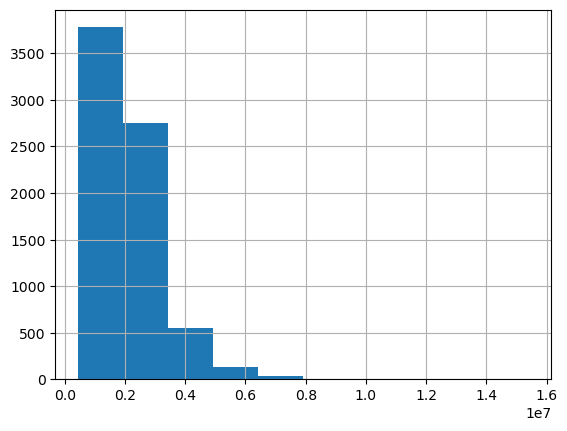

In [26]:
train_data['price'].hist()

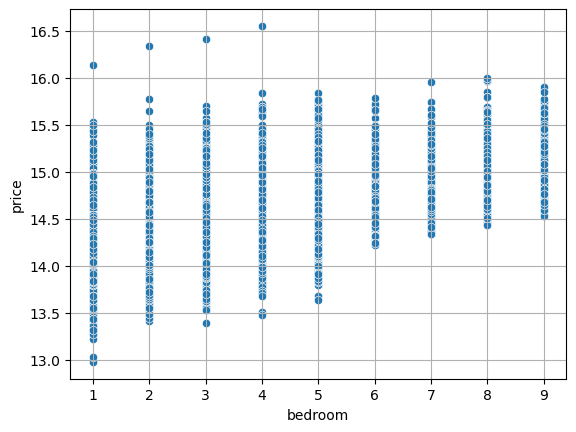

In [27]:
sns.scatterplot(x=train_data['bedroom'], y= np.log(train_data['price']))
plt.grid()

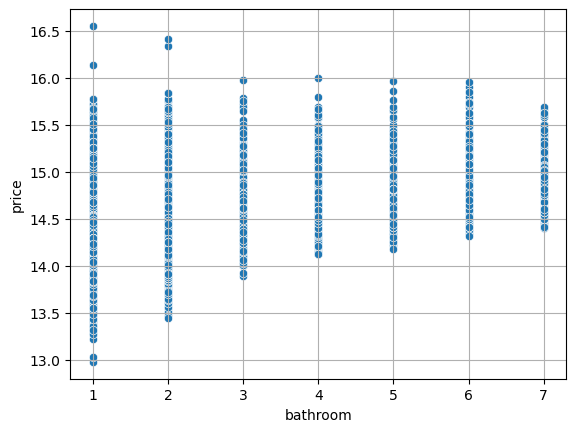

In [28]:
sns.scatterplot(x=train_data['bathroom'], y= np.log(train_data['price']))
plt.grid()

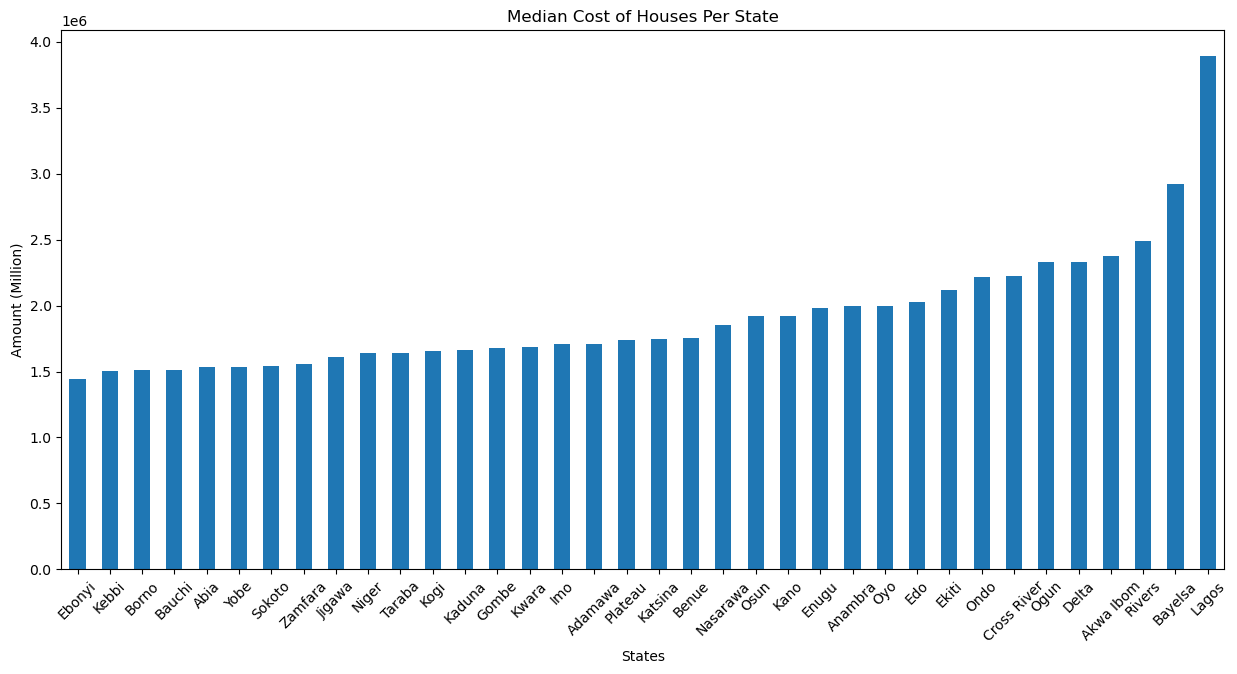

In [29]:
data = train_data.groupby('loc').median().sort_values(by='price',ascending=True)['price']
plt.figure(figsize=(15,7))
data.plot.bar();
plt.title('Median Cost of Houses Per State');
plt.ylabel("Amount (Million)");
plt.xlabel("States");
plt.xticks(rotation=45);

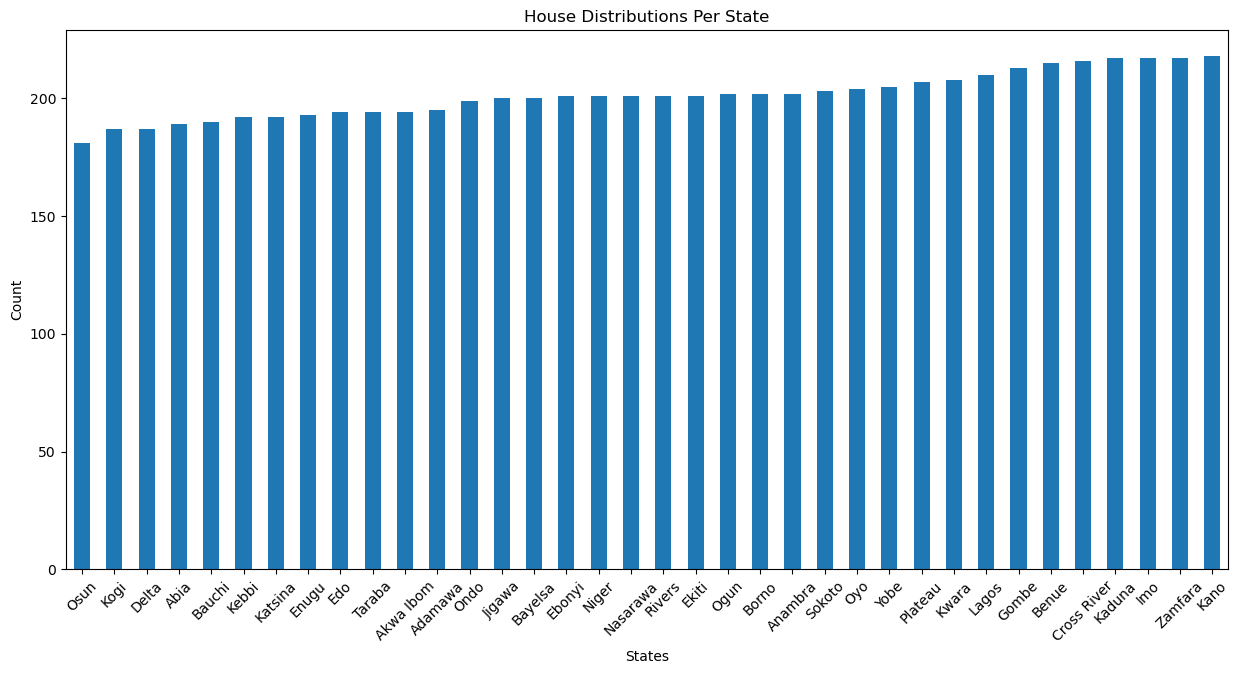

In [30]:
data = train_data.groupby('loc').count().sort_values(by='price',ascending=True)['price']
plt.figure(figsize=(15,7))
data.plot.bar();
plt.title('House Distributions Per State');
plt.ylabel("Count");
plt.xlabel("States");
plt.xticks(rotation=45);

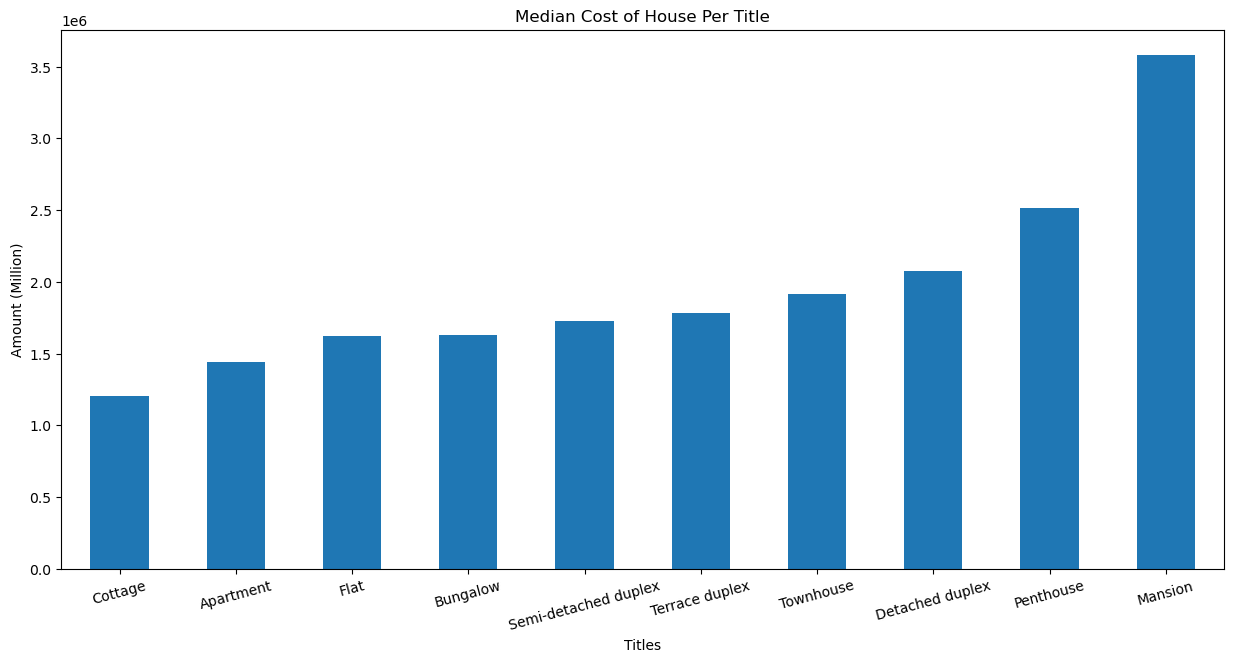

In [31]:
data = train_data.groupby('title').median().sort_values(by='price',ascending=True)['price']
plt.figure(figsize=(15,7))
data.plot.bar();
plt.title('Median Cost of House Per Title');
plt.ylabel("Amount (Million)");
plt.xlabel("Titles");
plt.xticks(rotation=15);

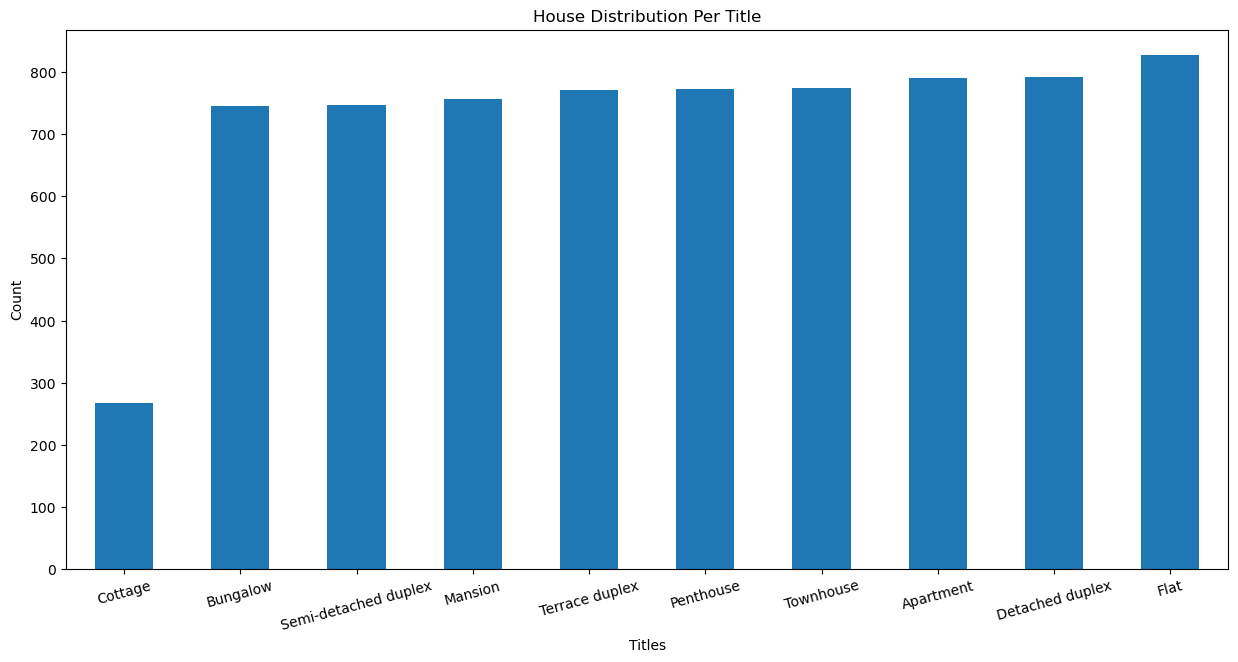

In [32]:
data = train_data.groupby('title').count().sort_values(by='price',ascending=True)['price']
plt.figure(figsize=(15,7))
data.plot.bar();
plt.title('House Distribution Per Title');
plt.ylabel("Count");
plt.xlabel("Titles");
plt.xticks(rotation=15);

## Summary

* Our prices are highly skrewed.
* Both Bedroom and Bathroom are postively correlated with price.
* The dataset house distributions per state are almost even, so one can argue that the median price are not affected by quantity though we can't deny the presence of outliers.
* One can make a case for Cottage low median price due to its low quantity in the dataset but a closer will reveal otherview, Flat had the highest distribution yet was the 3rd lowest.

## Helper Functions / Feature Engineering

In [33]:
statelist = train_data.groupby('loc').median().sort_values(by='price',ascending=True).index
title_list = train_data.groupby('title').median().sort_values(by='price',ascending=True).index


def ordinalEncoding_loc(X):
    nums = np.array(range(1,len(statelist)+1))
    chocieList =  (nums-nums.mean())/nums.std()
    result = np.select([X == state for state in statelist],nums)
    return result

def ordinalEncoding_title(X):
    nums = np.array(range(1,len(title_list)+1))
    chocieList =  (nums-nums.mean())/nums.std()
    result = np.select([X == title for title in title_list],nums)
    return result

In [34]:
groupings = train_data.groupby(['loc','title']).median().sort_values(by='price',ascending=False)['price'].unstack()
title_rank = train_data.groupby('title').median().sort_values(by='price',ascending=True).index
title_rank = list(title_rank)
title_loc_ordering = {}

for title in groupings.columns:
    rank = title_rank.index(title) + 1
    shift = 36 * (rank - 1)
    title_loc_ordering[title] =  list(groupings[title].sort_values(ascending=True).index)
    title_loc_ordering[title].append(rank)
    title_loc_ordering[title].append(shift)
    
def get_rank(x):
    title,location = x.split('&')
    index = title_loc_ordering[title].index(location) + 1
    deviation = title_loc_ordering[title][-1]
    weight = title_loc_ordering[title][-2]
    return index + weight + deviation


def create_rank(X):
    df  = X.copy()
    features_comb = df['title'] + '&' + df['loc']
    df['rank'] = features_comb.apply(lambda x : get_rank(x))
    mean = df.groupby(['loc'])['rank'].transform('mean')
    # std = df.groupby(['loc'])['rank'].transform('std')
    min_ = df.groupby(['loc'])['rank'].transform('min')
    max_ = df.groupby(['loc'])['rank'].transform('max')
    return (df['rank'] - mean) /(max_- min_)

In [35]:
groupings = train_data.groupby(['title','loc']).median().sort_values(by='price',ascending=False)['price'].unstack()
loc_rank = train_data.groupby('title').median().sort_values(by='price',ascending=True).index
loc_rank = list(loc_rank)
loc_title_ordering = {}

for location in groupings.columns:
    rank = loc_rank.index(title) + 1
    shift = 10 * (rank - 1)
    loc_title_ordering[location] =  list(groupings[location].sort_values(ascending=True).index)
    loc_title_ordering[location].append(rank)
    loc_title_ordering[location].append(shift)
    
def get_rank_loc(x):
    title,location = x.split('&')
    index = loc_title_ordering[location].index(title) + 1
    deviation = loc_title_ordering[location][-1]
    weight = loc_title_ordering[location][-2]
    return index + weight + deviation


def create_rank_loc(X):
    df  = X.copy()
    features_comb = df['title'] + '&' + df['loc']
    df['rank'] = features_comb.apply(lambda x : get_rank(x))
    mean = df.groupby(['title'])['rank'].transform('mean')
    # std = df.groupby(['loc'])['rank'].transform('std')
    min_ = df.groupby(['title'])['rank'].transform('min')
    max_ = df.groupby(['title'])['rank'].transform('max')
    return (df['rank'] - mean) /(max_- min_)

In [36]:
def create_features(data):
    df = data.copy()
    df['loc_ordinal'] = ordinalEncoding_loc(df['loc'])
    df['title_ordinal'] = ordinalEncoding_title(df['title'])
    df['title_rank'] = create_rank(df[['title','loc']])
    df['loc_rank'] = create_rank_loc(df[['title','loc']])
    
    df['title_ordinal_2'] = df['title_rank'] * df['title_ordinal']
    
    # df['terrain'] = df['loc_ordinal']  *  df['title_ordinal']
    df['terrain_2'] = df['loc_ordinal']  * df['title_ordinal_2']
    
    # df['terrain_bed_2'] = df['terrain'] * df['bedroom'] 
    df['terrain_bed'] = df['title_rank'] * df['bedroom'] * df['loc_rank']
    # let's drop title rank cos it is almost the same with title_ordinal  
    #  We will also drop title_ordinal_2 cos it is almost the same with title_ordinal  
    df = df.drop(['title_ordinal_2','title_ordinal','loc_ordinal','title_rank'],axis=1)
    
    return df

In [37]:
def drop_loc_title(df):
    return df.drop(['loc','title'],axis=1)

In [38]:
features_train_data = create_features(train_data)

In [39]:
features_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7248 entries, 0 to 13997
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loc            7248 non-null   object 
 1   title          7248 non-null   object 
 2   bedroom        7248 non-null   float64
 3   bathroom       7248 non-null   float64
 4   parking_space  7248 non-null   float64
 5   price          7248 non-null   float64
 6   loc_rank       7248 non-null   float64
 7   terrain_2      7248 non-null   float64
 8   terrain_bed    7248 non-null   float64
dtypes: float64(7), object(2)
memory usage: 824.3+ KB


In [40]:
features_train_data.describe()

,bedroom,bathroom,parking_space,price,loc_rank,terrain_2,terrain_bed
count,7248.000000,7248.000000,7248.000000,7.248000e+03,7.248000e+03,7248.000000,7248.000000
mean,4.275662,2.348786,3.129001,2.128737e+06,-8.822964e-18,15.008000,0.002888
std,2.428194,1.645994,1.472267,1.057984e+06,2.958649e-01,40.589176,0.423816
min,1.000000,1.000000,1.000000,4.319673e+05,-5.115805e-01,-37.714286,-2.130000
25%,2.000000,1.000000,2.000000,1.396366e+06,-2.544377e-01,-11.937014,-0.160299
50%,4.000000,2.000000,3.000000,1.888039e+06,-4.595940e-03,0.732292,-0.000997
75%,6.000000,3.000000,4.000000,2.576923e+06,2.598481e-01,26.565488,0.173734
max,9.000000,7.000000,6.000000,1.540273e+07,5.124482e-01,160.372390,2.041259


In [41]:
features_train_data.var().sort_values(ascending=False)

C:\Users\EMEKA ONWUEPE\AppData\Local\Temp\ipykernel_9040\3849367518.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  features_train_data.var().sort_values(ascending=False)


price            1.119330e+12
terrain_2        1.647481e+03
bedroom          5.896126e+00
bathroom         2.709296e+00
parking_space    2.167571e+00
terrain_bed      1.796196e-01
loc_rank         8.753601e-02
dtype: float64

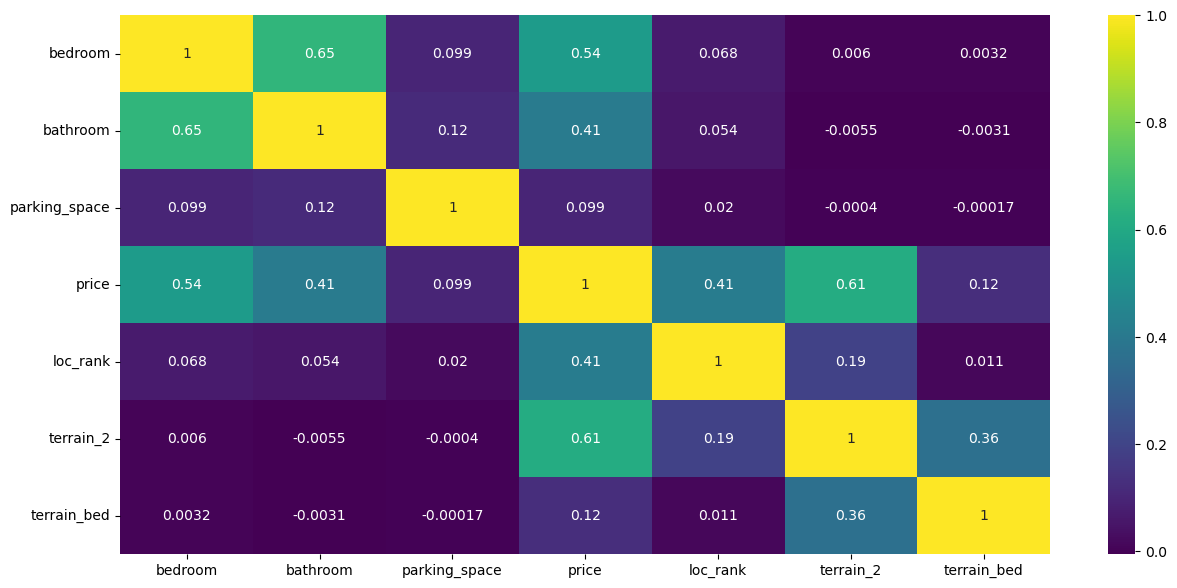

In [42]:
plt.figure(figsize=(15,7));
sns.heatmap(features_train_data.corr(),annot=True,cmap='viridis');

<AxesSubplot:xlabel='terrain_bed', ylabel='price'>

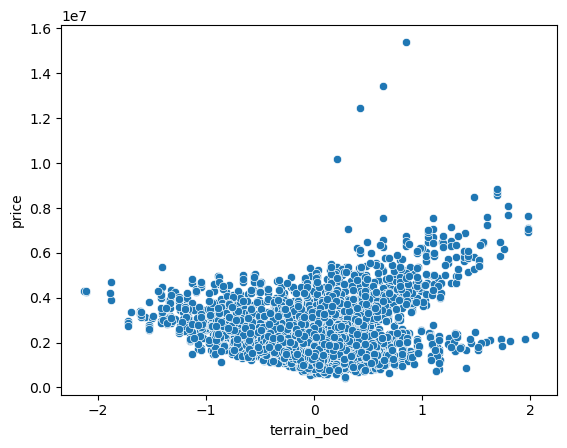

In [43]:
sns.scatterplot(x=features_train_data['terrain_bed'], y=train_data['price'])

<AxesSubplot:xlabel='loc_rank', ylabel='price'>

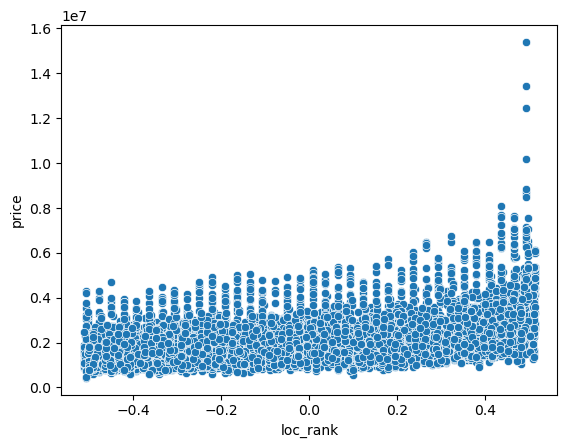

In [44]:
sns.scatterplot(x=features_train_data['loc_rank'], y=train_data['price'])

# KMeans Clusttering

In [45]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=239, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        # prediction = self.kmeans_.predict(X)
        # return prediction.reshape(-1,1)
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

# Pipeline

In [46]:
num_pipeline = make_pipeline(
    FunctionTransformer(create_features),
    FunctionTransformer(drop_loc_title),
    MinMaxScaler(),  
)

cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    )


cluster_pipeline = make_pipeline(
    ColumnTransformer([
   
    ("one_hot", cat_pipeline, ['loc','title']),
    ],remainder= 'passthrough'),
   
    ClusterSimilarity(n_clusters=36, gamma= 1., random_state=42),
     
)

In [47]:
preprocessing = make_pipeline( 
        ColumnTransformer([
        ("num", num_pipeline,make_column_selector(dtype_exclude=None)),
        ("cat", cat_pipeline,  make_column_selector(dtype_include=object) ),   
        ("geo", cluster_pipeline, ['loc',"title",'bedroom','bathroom']),
        ]),
    )

In [48]:
model = TransformedTargetRegressor(svm.SVR(gamma=0.2),
                                  transformer = StandardScaler() )

reg_model = Pipeline([('preprocessing', preprocessing) ,('model', model)] )

reg_model

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('functiontransformer-1',
                                                                                    FunctionTransformer(func=<function create_features at 0x000001E1E2C7FE20>)),
                                                                                   ('functiontransformer-2',
                                                                                    FunctionTransformer(func=<function drop_loc_title at 0x000001E1E2CE0160>)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler()...
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('one_hot',
                                                                                                                     Pipeline(steps=[('onehotencoder',
                                                                                                                                      OneHotEncoder(handle_unknown='ignore'))]),
                                                                                                                     ['loc',
                                                                                                                      'title'])])),
                                                                                   ('clustersimilarity',
                                                                                    ClusterSimilarity(n_clusters=36,
                                                                                                      random_state=42))]),
                                                                   ['loc',
                                                                    'title',
                                                                    'bedroom',
                                                                    'bathroom'])]))])),
                ('model',
                 TransformedTargetRegressor(regressor=SVR(gamma=0.2),
                                            transformer=StandardScaler()))])

In [49]:
train_data.drop('price',axis=1)

,loc,title,bedroom,bathroom,parking_space
0,Katsina,Semi-detached duplex,2.0,2.0,1.0
3,Anambra,Detached duplex,5.0,2.0,4.0
7,Katsina,Penthouse,3.0,3.0,5.0
10,Ogun,Bungalow,1.0,1.0,6.0
11,Bayelsa,Apartment,3.0,2.0,2.0
...,...,...,...,...,...
13989,Kebbi,Terrace duplex,4.0,3.0,2.0
13990,Kebbi,Penthouse,8.0,7.0,3.0
13992,Ogun,Cottage,1.0,1.0,2.0
13994,Taraba,Detached duplex,8.0,1.0,6.0


In [50]:
# Train / test split
strat_train_set, strat_test_set = train_test_split(
    train_data, test_size=0.3, stratify=train_data["title"], random_state=42)

train_features = strat_train_set.drop('price',axis=1)
train_label = strat_train_set.price

test_features = strat_test_set.drop('price',axis=1)
test_label = strat_test_set.price

In [51]:
reg_model.fit(train_features, train_label)
housing_predictions = reg_model.predict(test_features)
model_rmse = mean_squared_error(test_label, housing_predictions,
                                 squared=False)
model_rmse

306658.5793322587

In [52]:
reg_model.fit(train_data.drop('price',axis=1), train_data.price)
housing_forcast = reg_model.predict(test_data)

print(housing_forcast)

print(test_ids)

data = {'ID':test_ids,'price':housing_forcast}

submission = pd.DataFrame(data)
submission.set_index('ID',inplace=True)
submission.to_csv('forcast.csv')

[2298072.12714546  927839.4900768  1066426.75574132 ... 1913524.52672385
 1244113.15920314 3252673.20330577]
0         845
1        1924
2       10718
3       12076
4       12254
        ...  
5995     1594
5996     2416
5997    10195
5998     9455
5999    11736
Name: ID, Length: 6000, dtype: int64


In [53]:
housing_predictions = reg_model.predict(train_data.drop('price',axis=1))
model_rmse = mean_squared_error(train_data.price, housing_predictions,
                                 squared=False)
model_rmse

335453.899041013

In [54]:
# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {
#         # 'model__regressor__gamma': np.array(list(range(1,11))) /10,
#         'preprocessing__columntransformer__geo__clustersimilarity__n_clusters': [6,10,36,40,41,75,360,366,378,720] ,
#         # 'preprocessing__geo__steps__clustersimilarity__n_clusters': list(range(90,100))
#         # 'model__regressor__kernel': ('linear', 'rbf','poly', 'sigmoid'),
#       # 'model__regressor__C':  np.array(list(range(1,11))) /10,
#     }
# ]
# grid_search = GridSearchCV(reg_model, param_grid,
#                           scoring='neg_root_mean_squared_error')
# grid_search.fit(train_data.drop('price',axis=1), train_data.price)

In [55]:
# grid_search.best_params_

In [56]:
test_data.head()

,loc,title,bedroom,bathroom,parking_space
0,Kano,Penthouse,4,1,2
1,Adamawa,Apartment,2,2,4
2,Adamawa,Bungalow,2,1,2
3,Lagos,Mansion,9,5,2
4,Gombe,Semi-detached duplex,5,4,1
